# Sentiment Analysis on Amazon Product Reviews of Uplocked Mobile Phones

* #### [Part 1. Data Exploration](#part1) 
* #### [Part 2. Data Preparation](#part2) 
* #### [Part 3. Bag of Words](#part3)
* #### [Part 4. Word2Vec](#part4)
* #### [Part 5. LSTM](#part5)
* #### [Part 6. Word Cloud](#part6)

##### References : 
* [Data Source](https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones)
* [Working with text Data in sklearn](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
* [Using pre-trained word embeddings in a Keras model](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)
* [Deep Learning with Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html)
* [Deep Learning, NLP, and Representations](http://colah.github.io/posts/2014-07-NLP-RNNs-Representations/)
* [An Intuitive Understanding of Word Embeddings: From Count Vectors to Word2Vec](https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/)
* [Sequence Classification with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/)
* [Embedding and Tokenizer in Keras](http://www.orbifold.net/default/2017/01/10/embedding-and-tokenizer-in-keras/)

---
<a id="part1"></a>
## Part 1. Data Exploration

In [59]:
import pandas as pd
import numpy as np
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline


import re
import nltk
from bs4 import BeautifulSoup
import lxml
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

import logging
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda,SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K
from keras.layers.embeddings import Embedding

The data set is available for download from [Kaggle](https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones).

### Load Data

In [6]:



cnx = sqlite3.connect('/home/varuni/Documents/ML-LabProj/amazon-fine-food-reviews/database.sqlite')

df = pd.read_sql_query("SELECT * FROM Reviews", cnx)

### Data Exploration

In [8]:
print("Summary statistics of numerical features : \n", df.describe())

print("\nTotal number of reviews: ",len(df))
#print("\nTotal number of brands: ", len(list(set(df['Brand Name']))))
print("\nTotal number of unique products: ", len(list(set(df['ProductId']))))

print("\nPercentage of reviews with neutral sentiment : {:.2f}%"\
      .format(df[df['Score']==3]["Score"].count()/len(df)*100))
print("\nPercentage of reviews with positive sentiment : {:.2f}%"\
      .format(df[df['Score']>3]["Score"].count()/len(df)*100))
print("\nPercentage of reviews with negative sentiment : {:.2f}%"\
      .format(df[df['Score']<3]["Score"].count()/len(df)*100))

Summary statistics of numerical features : 
                   Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  568454.000000         568454.000000            568454.00000   
mean   284227.500000              1.743817                 2.22881   
std    164098.679298              7.636513                 8.28974   
min         1.000000              0.000000                 0.00000   
25%    142114.250000              0.000000                 0.00000   
50%    284227.500000              0.000000                 1.00000   
75%    426340.750000              2.000000                 2.00000   
max    568454.000000            866.000000               923.00000   

               Score          Time  
count  568454.000000  5.684540e+05  
mean        4.183199  1.296257e+09  
std         1.310436  4.804331e+07  
min         1.000000  9.393408e+08  
25%         4.000000  1.271290e+09  
50%         5.000000  1.311120e+09  
75%         5.000000  1.332720e+09  
max         5.000000  1.3512

### Data Visualization 

Text(0,0.5,'Count')

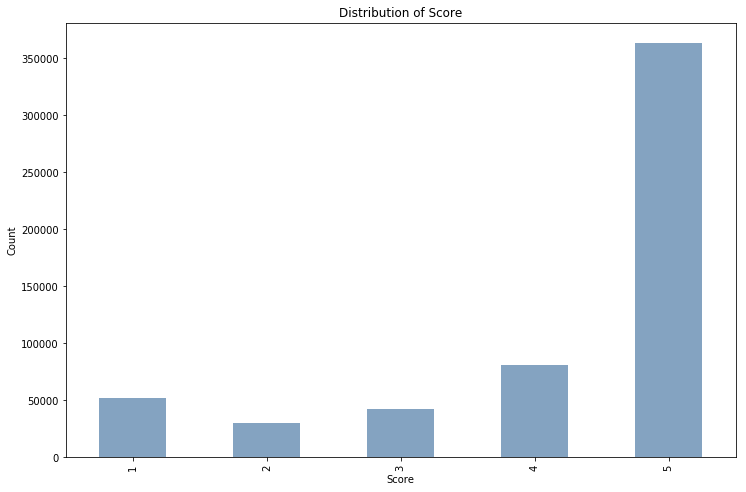

In [12]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
df['Score'].value_counts().sort_index().plot(kind='bar', color=(0.2, 0.4, 0.6, 0.6))
plt.title('Distribution of Score')
plt.xlabel('Score')
plt.ylabel('Count')

Text(0.5,1,'Number of Reviews for Top 50 Products')

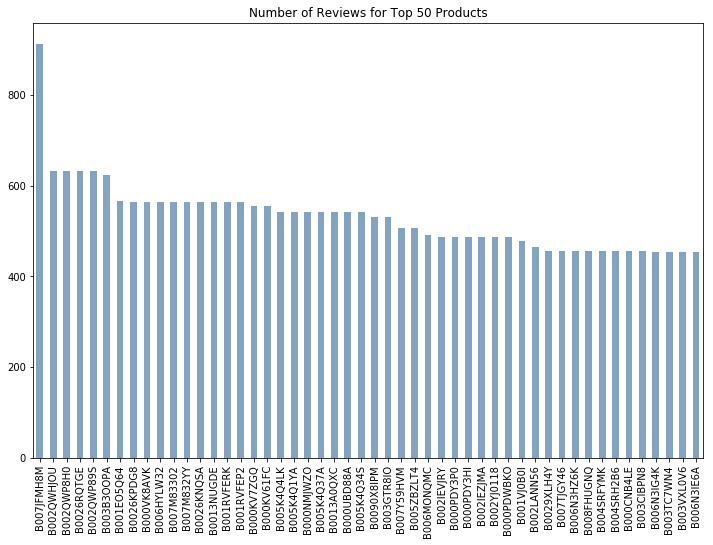

In [11]:
# Plot number of reviews for top 50 products
products = df["ProductId"].value_counts()
plt.figure(figsize=(12,8))
products[:50].plot(kind='bar', color=(0.2, 0.4, 0.6, 0.6))
plt.title("Number of Reviews for Top 50 Products")

Text(0,0.5,'Count')

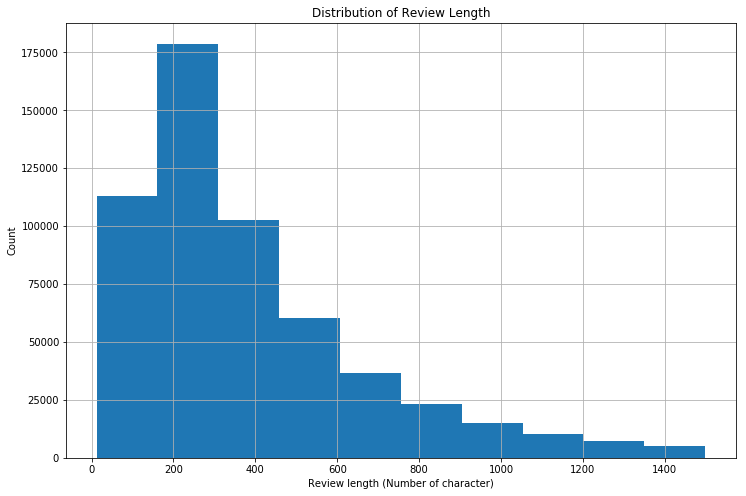

In [13]:
# Plot distribution of review length
review_length = df["Text"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

---
<a id="part2"></a>
## Part 2. Data Preparation

For illustrative purpose, I use only 10% of the data in this project. To simply the problem, I only consider reviews with positive sentiment (rating = 4, 5) and negative sentiment (rating = 1, 2), and drop reviews with neutral sentiment (rating 3). 


### Prepare Data

In [14]:
df = df.sample(frac=0.1, random_state=0) #uncomment to use full set of data

# Drop missing values
df.dropna(inplace=True)

# Remove any 'neutral' ratings equal to 3
df = df[df['Score'] != 3]

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['Sentiment'] = np.where(df['Score'] > 3, 1, 0)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
11214,11215,B001KVPC0G,A1FJEIB7HQ22ME,Marty Whitman,5,5,5,1334188800,Yes!!!,I could live off of these! I'm not kidding. Th...,1
222079,222080,B000OJ1H36,A1P59RM84ZIA0C,trail mix junkie,0,0,5,1325808000,Tropical Trail Mix,I found this product in a local grocery store ...,1
251082,251083,B0009F8JRC,ASPAJS6WD8CWY,Lanette Hawkes,1,2,5,1223510400,Great Gummies!,My young son is taking Chinese in school and w...,1
317731,317732,B005K4Q1RW,A2020KL55SYZ4U,Paula E. Williams,0,0,5,1334534400,I'm addicted to this!,I love Grove Square Spiced Apple Cider Cups (s...,1
404652,404653,B00153C4B4,A22BGI38W7Q9X9,PracticalWaysToSaveMoney,0,0,2,1332547200,"Tastes Eh, Very Expensive",This is probably my shortest review but there'...,0


### Train Test Split 

In [36]:
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Sentiment'], \
                                                    test_size=0.1, random_state=0)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

Load 47393 training examples and 5266 validation examples. 

Show a review in the training set : 
 I am the companion to a small dog of unknown age and breed who has been troubled with a tender tummy for a few years.  Her vet has tons of medications to give her, but I don't need any of them since I tried the Wellness brand dry dog food and the moist.<br /><br />All her problems gave gone away.  It is amazing.  She has not been to the vet since her last yearly checkup.


---
<a id="part3"></a>
## Part 3. Bag of Words

The goal of this project is to classify the reviews into positive and negative sentiment. There are two main steps involved. First, we need to find a word embedding to convert a text into a numerical representation. Second, we fit the numerical representations of text to machine learning algorithms or deep learning architectures.

One common approach of word embedding is frequency based embedding such as Bag of Words (BoW) model. BoW model learns a vocubulary list from a given corpus and represents each document based on some counting methods of words. In this part, we will explore the model performance of using BoW with supervised learning algorithms. Here's the workflow in this part.

* Step 1 : Preprocess raw reviews to cleaned reviews
* Step 2 : Create BoW using CountVectorizer / Tfidfvectorizer in sklearn
* Step 3 : Transform review text to numerical representations (feature vectors)
* Step 4 : Fit feature vectors to supervised learning algorithm (eg. Naive Bayes, Logistic regression, etc.)
* Step 5 : Improve the model performance by GridSearch

### Text Preprocessing

The following text preprocessing are implemented to convert raw reviews to cleaned review, so that it will be easier for us to do feature extraction in the next step.
* remove html tags using BeautifulSoup
* remove non-character such as digits and symbols
* convert to lower case
* remove stop words such as "the" and "and" if needed
* convert to root words by stemming if needed

In [37]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'html.parser').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words)) 

In [38]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

Show a cleaned review in the training set : 
 i am the companion to a small dog of unknown age and breed who has been troubled with a tender tummy for a few years her vet has tons of medications to give her but i don t need any of them since i tried the wellness brand dry dog food and the moist all her problems gave gone away it is amazing she has not been to the vet since her last yearly checkup


### CountVectorizer with Multinomial Naive Bayes (Benchmark Model)

Now we have cleaned reviews, the next step is to convert the reviews into numerical representations for machine learning algorithm. 

In sklearn library, we can use CountVectorizer which implements both tokenization and occurrence counting in a single class. The output is a sparse matrix representation of a document.

In [39]:
# Fit and transform the training data to a document-term matrix using CountVectorizer
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" %len(countVect.get_feature_names())) #6378 
print("Show some feature names : \n", countVect.get_feature_names()[::1000])


# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)

Number of features : 40602 

Show some feature names : 
 ['aa', 'alo', 'asparatame', 'behaviorist', 'bourbon', 'cancelled', 'chezus', 'columnist', 'counseletmillard', 'deceiving', 'disapponted', 'earily', 'ethylene', 'fibrous', 'freind', 'glutens', 'halfdead', 'horked', 'ingested', 'jovial', 'lcd', 'lyrically', 'merlotte', 'much', 'np', 'outlawed', 'penning', 'pomace', 'provides', 'recommendthat', 'rhode', 'scallops', 'shone', 'sold', 'steviosides', 'sweaty', 'themgot', 'treatable', 'unshelled', 'walnut', 'wouoldn']


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [40]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [41]:
# Evaluate the model on validaton set
predictions = mnb.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9064

AUC score : 0.7859

Classification report : 
              precision    recall  f1-score   support

          0       0.73      0.61      0.67       805
          1       0.93      0.96      0.95      4461

avg / total       0.90      0.91      0.90      5266


Confusion Matrix : 
 [[ 493  312]
 [ 181 4280]]


### TfidfVectorizer with Logistic Regression

Some words might frequently appear but have little meaningful information about the sentiment of a particular review. Instead of using occurance counting, we can use tf-idf transform to scale down the impact of frequently appeared words in a given corpus. 

In sklearn library, we can use TfidfVectorizer which implements both tokenization and tf-idf weighted counting in a single class.

In [42]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 13112 

Show some feature names : 
 ['00', 'avoided', 'categories', 'crunchier', 'emails', 'gatorade', 'induced', 'maggi', 'offspring', 'proclaims', 'saltiest', 'ss', 'toward', 'xxx']


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [43]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['not' 'worst' 'disappointed' 'terrible' 'awful' 'horrible'
 'disappointing' 'money' 'weak' 'disappointment']

Top 10 features with largest coefficients : 
['great' 'best' 'delicious' 'love' 'good' 'perfect' 'excellent' 'nice'
 'loves' 'wonderful']


In [44]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9220

AUC score : 0.7809

Classification report : 
              precision    recall  f1-score   support

          0       0.87      0.58      0.69       805
          1       0.93      0.98      0.96      4461

avg / total       0.92      0.92      0.92      5266


Confusion Matrix : 
 [[ 465  340]
 [  71 4390]]


### Pipeline and GridSearch

In sklearn library, we can build a pipeline to streamline the workflow and use GridSearch on the pipeline model to implement hyper-parameter tuning for both vectorizer and classifier in one go.

In [45]:
# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.1, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 3], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_cleaned, y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)
modelEvaluation(predictions)

KeyboardInterrupt: 

---
<a id="part4"></a>
## Part 4. Word2Vec

Another common approach of word embedding is prediction based embedding, such as Word2Vec model. In gist, Word2Vec is a combination of two techniques: Continuous Bag of Words (CBoW) and skip-gram model. Both are shallow neural networks which learn weights for word vector representations.

In this part, we will train Word2Vec model to create our own word vector representations using gensim library. Then we fit the feature vectors of the reviews to Random Forest Classifier. Here's the workflow of this part.

* Step 1 : Parse review text to sentences (Word2Vec model takes a list of sentences as inputs)
* Step 2 : Create volcabulary list using Word2Vec model
* Step 3 : Transform each review into numerical representation by computing average feature vectors of words therein
* Step 4 : Fit the average feature vectors to Random Forest Classifier

### Parsing Review into Sentences

Word2Vec model takes a list of sentences as inputs and outputs word vector representations for words in the vocalbulary list created. Before we train the Word2Vec model, we have to parse reviews in the training set into sentences.

In [46]:
# Split review text into parsed sentences uisng NLTK's punkt tokenizer
# nltk.download()
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords, split_text=True))
    return sentences


# Parse each review in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)
    
print('%d parsed sentence in the training set\n'  %len(sentences))
print('Show a parsed sentence in the training set : \n',  sentences[10])

47393 parsed sentence in the training set

Show a parsed sentence in the training set : 
 ['i', 'am', 'the', 'companion', 'to', 'a', 'small', 'dog', 'of', 'unknown', 'age', 'and', 'breed', 'who', 'has', 'been', 'troubled', 'with', 'a', 'tender', 'tummy', 'for', 'a', 'few', 'years', 'her', 'vet', 'has', 'tons', 'of', 'medications', 'to', 'give', 'her', 'but', 'i', 'don', 't', 'need', 'any', 'of', 'them', 'since', 'i', 'tried', 'the', 'wellness', 'brand', 'dry', 'dog', 'food', 'and', 'the', 'moist', 'all', 'her', 'problems', 'gave', 'gone', 'away', 'it', 'is', 'amazing', 'she', 'has', 'not', 'been', 'to', 'the', 'vet', 'since', 'her', 'last', 'yearly', 'checkup']


### Creating Volcabulary List usinhg Word2Vec Model

Now we have a set of cleaned and parsed sentences from the training data, we can train our own word evctor representations by sepcifiying the embedding dimension (= length of feature vector).

In [47]:
# Fit parsed sentences to Word2Vec model 
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

num_features = 300  #embedding dimension                     
min_word_count = 10                
num_workers = 4       
context = 10                                                                                          
downsampling = 1e-3 

print("Training Word2Vec model ...\n")
w2v = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,\
                 window = context, sample = downsampling)
w2v.init_sims(replace=True)
w2v.save("w2v_300features_10minwordcounts_10context") #save trained word2vec model

print("Number of words in the vocabulary list : %d \n" %len(w2v.wv.index2word)) #4016 
print("Show first 10 words in the vocalbulary list  vocabulary list: \n", w2v.wv.index2word[0:10])

Training Word2Vec model ...

Number of words in the vocabulary list : 9338 

Show first 10 words in the vocalbulary list  vocabulary list: 
 ['the', 'i', 'and', 'a', 'it', 'to', 'of', 'is', 'this', 'in']


### Averaging Feature Vectors

Now we have created a volcabulary list of words, with each word having a word representation (ie. feature vector of dim 300).

To find a numerical representation for a review, we run through each word in a review text. For words appear in the volcabulary list, we compute the average feature vectors of all those words. The average feature vector is the numerical represenation of the review. 

In [48]:
# Transfrom the training data into feature vectors

def makeFeatureVec(review, model, num_features):
    '''
    Transform a review to a feature vector by averaging feature vectors of words 
    appeared in that review and in the volcabulary list created
    '''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word) #index2word is the volcabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
            isZeroVec = False
    if isZeroVec == False:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Transform all reviews to feature vectors using makeFeatureVec()
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [49]:
# Get feature vectors for training set
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" %trainVector.shape)


# Get feature vectors for validation set
X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" %testVector.shape)


# debugging
# print("Checkinf for NaN and Inf")
# print("np.inf=", np.where(np.isnan(trainVector)))
# print("is.inf=", np.where(np.isinf(trainVector)))
# print("np.max=", np.max(abs(trainVector)))

/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


Training set : 47393 feature vectors with 300 dimensions
Validation set : 5266 feature vectors with 300 dimensions


### Random Forest Classifer

We can now train Random Forest Classifier using feature vectors of reviews in the training set. 

In [50]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)
modelEvaluation(predictions)


Accuracy on validation set: 0.8963

AUC score : 0.7011

Classification report : 
              precision    recall  f1-score   support

          0       0.81      0.42      0.55       805
          1       0.90      0.98      0.94      4461

avg / total       0.89      0.90      0.88      5266


Confusion Matrix : 
 [[ 338  467]
 [  79 4382]]


---
<a id="part5"></a>
## Part 5. LSTM

Long Short Term Memory networks (LSTM) are a special kind of Recurrent Neural Networks (RNN), capable of learning long-term dependencies. LSTM can be very usefull in text mining problems since it involves dependencies in the sentences which can be caught in the "memory" of the LSTM.

In this part, we train a simple LSTM and a LSTM with Word2Vec embedding to classify the reviews into positive and negative  sentiment using Keras libarary.

### Simple LSTM

We need to preprocess the text data to 2D tensor before we fit into a simple LSTM. First, we tokenize the corpus by only considering top words (top_words = 20000), and transform reviews to numerical sequences using the trained tokenizer. Next, we make sure that all numerical sequences have the same length (maxlen=100) for modeling, by truncating long reviews and pad shorter reviews with zero values.

To construct a simple LSTM, we use embedding class in Keras to construct the first layer. This embedding layer converts numerical sequence of words into a word embedding. We should note that the embedding class provides a convenient way to map discrete words into a continuous vector space, but it does not take the semantic similarity of the words into account. The next layer is the LSTM layer with 128 memory units. Finally, we use a dense output layer with a single neuron and a sigmoid activation function to make 0 or 1 predictions for the two classes (positive sentiment and negative sentiment). Since it is a binary classification problem, log loss is used as the loss function (binary_crossentropy in Keras). ADAM optimization algorithm is used.

Here's the workflow in this part.
* Step 1 : Prepare X_train and X_test to 2D tensor
* Step 2 : Train a simple LSTM (embeddign layer => LSTM layer => dense layer)
* Step 3 : Compile and fit the model using log loss function and ADAM optimizer

In [52]:
top_words = 20000 
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(num_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

X_train shape: (47393, 100)
X_test shape: (5266, 100)
y_train shape: (47393, 2)
y_test shape: (5266, 2)


In [61]:
# Construct a simple LSTM
model1 = Sequential()
model1.add(Embedding(top_words, 128))
model1.add(SpatialDropout1D(0.2))
model1.add(LSTM(128, dropout_W=0.2, recurrent_dropout=0.2)) 
model1.add(Dense(nb_classes))
model1.add(Activation('softmax'))
model1.summary()

# Compile LSTM
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1.fit(X_train_seq, y_train_seq, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)

# Model evluation
score = model1.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
model1.save("lstm.h5")
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, recurrent_dropout=0.2, dropout=0.2)`
  """


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, None, 128)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 2,691,842
Trainable params: 2,691,842
Non-trainable params: 0
_________________________________________________________________


/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/3
47393/47393 [==============================] - 1256s 26ms/step - loss: 0.2672 - acc: 0.8939
Epoch 2/3
47393/47393 [==============================] - 1233s 26ms/step - loss: 0.1699 - acc: 0.9349
Epoch 3/3
5266/5266 [==============================] - 31s 6ms/step
Test loss : 0.2087
Test accuracy : 0.9284


In [68]:
# get weight matrix of the embedding layer
model1.layers[0].get_weights()[0] # weight matrix of the embedding layer, word-by-dim matrix
print("Size of weight matrix in the embedding layer : ", \
      model1.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model1.layers[1].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model1.layers[2].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (20000, 128)


IndexError: list index out of range

### LSTM with Word2Vec Embedding

In the simple LSTM model constructed above, the embedding class in Keras comes in handy to converts numerical sequence of words into a word embedding, but it does not take the semantic similarity of the words into account.  The model assigns random weights to the embedding layer and learn the embeddings by minimizing the global error of the network.

Instead of using random weights, we can use pretrained word embeddings to initialize the weight of an embedding layer. In this part, we use the Word2Vec embedding trained in Part 4 to 
intialize the weights of embedding layer in LSTM.

* Step 1 : Load pretrained word embedding model
* Step 2 : Construct embedding layer using embedding matrix as weights
* Step 3 : Train a LSTM with Word2Vec embedding (embeddign layer => LSTM layer => dense layer)
* Step 4 : Compile and fit the model using log loss function and ADAM optimizer

In [64]:
# Load trained Word2Vec model
w2v = Word2Vec.load("w2v_300features_10minwordcounts_10context")


# Get Word2Vec embedding matrix
embedding_matrix = w2v.wv.vectors  # embedding matrix, type = numpy.ndarray 
print("Shape of embedding matrix : ", embedding_matrix.shape) #(4016, 300) = (volcabulary size, embedding dimension)
# w2v.wv.syn0[0] #feature vector of the first word in the volcabulary list

Shape of embedding matrix :  (9338, 300)


In [65]:
top_words = embedding_matrix.shape[0] #4016
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(num_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

X_train shape: (47393, 100)
X_test shape: (5266, 100)
y_train shape: (47393, 2)
y_test shape: (5266, 2)


In [66]:
# Construct Word2Vec embedding layer
embedding_layer = Embedding(embedding_matrix.shape[0], #4016
                            embedding_matrix.shape[1], #300
                            weights=[embedding_matrix])


# Construct LSTM with Word2Vec embedding
model2 = Sequential()
model2.add(embedding_layer)
model2.add(LSTM(128, dropout_W=0.2, dropout_U=0.2
               )) 
model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))
model2.summary()

# Compile model
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs  =nb_epoch, verbose=1)


# Model evaluation
score = model2.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
model2.save("lstmw2.h5")
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.2, recurrent_dropout=0.2)`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 300)         2801400   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total params: 3,021,306
Trainable params: 3,021,306
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
47393/47393 [==============================] - 1321s 28ms/step - loss: 0.2661 - acc: 0.8948
Epoch 2/3
47393/47393 [==============================] - 1318s 28ms/step - loss: 0.1589 - acc: 0.9390
Epoch 3/3
5266/5266 [==============================] - 37s 7

In [67]:
# get weight matrix of the embedding layer
print("Size of weight matrix in the embedding layer : ", \
      model2.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model2.layers[1].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model2.layers[2].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (9338, 300)
Size of weight matrix in the hidden layer :  (300, 512)
Size of weight matrix in the output layer :  (128, 2)


---
<a id="part6"></a>
## Part 6. Word Cloud

In this part, we create word clouds for positive sentiment reviews and negative sentiment reviews of a selected brand, to get an intuition of words frequently appear in different sentiments.

In [31]:
def create_word_cloud(brand, sentiment):
    try: 
        df_brand = df.loc[df['Brand Name'].isin([brand])]
        df_brand_sample = df_brand.sample(frac=0.1)
        word_cloud_collection = ''
        
        if sentiment == 1:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==1]["Reviews"]
            
        if sentiment == 0:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==0]["Reviews"]
            
        for val in df_reviews.str.lower():
            tokens = nltk.word_tokenize(val)
            tokens = [word for word in tokens if word not in stopwords.words('english')]
            for words in tokens:
                word_cloud_collection = word_cloud_collection + words + ' '

        wordcloud = WordCloud(max_font_size=50, width=500, height=300).generate(word_cloud_collection)
        plt.figure(figsize=(20,20))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
    except: 
        pass

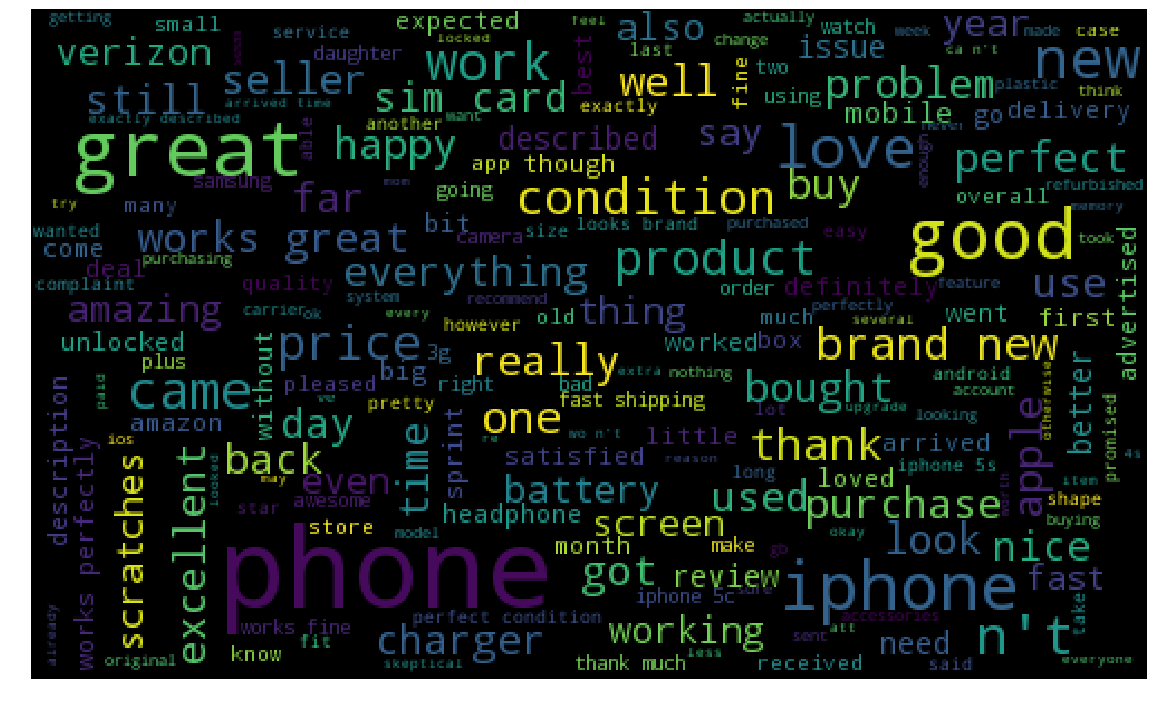

In [32]:
create_word_cloud(brand='Apple', sentiment=1)

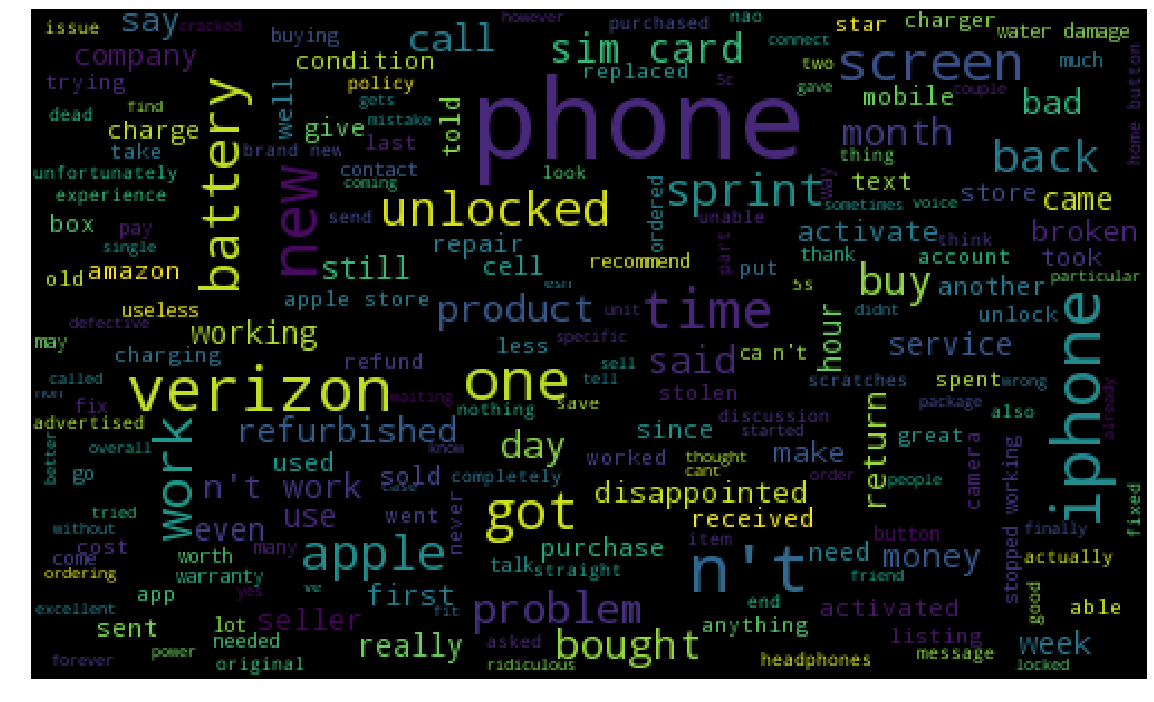

In [33]:
create_word_cloud(brand='Apple', sentiment=0)

In [1]:
print("Size of weight matrix in the output layer : ", \
      model2.layers[2].get_weights()[0].shape) #(128, 2) weight dim of dense layer

NameError: name 'model2' is not defined